In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from io import StringIO

aa = '''iupac\tthree_letter	name
A	Ala	Alanine
C	Cys	Cysteine
D	Asp	Aspartic Acid
E	Glu	Glutamic Acid
F	Phe	Phenylalanine
G	Gly	Glycine
H	His	Histidine
I	Ile	Isoleucine
K	Lys	Lysine
L	Leu	Leucine
M	Met	Methionine
N	Asn	Asparagine
P	Pro	Proline
Q	Gln	Glutamine
R	Arg	Arginine
S	Ser	Serine
T	Thr	Threonine
V	Val	Valine
W	Trp	Tryptophan
Y	Tyr	Tyrosine'''
aa_df = pd.read_csv(StringIO(aa), sep='\t')
aa_df
aminoacids = aa_df['iupac']


<Figure size 1584x3672 with 0 Axes>

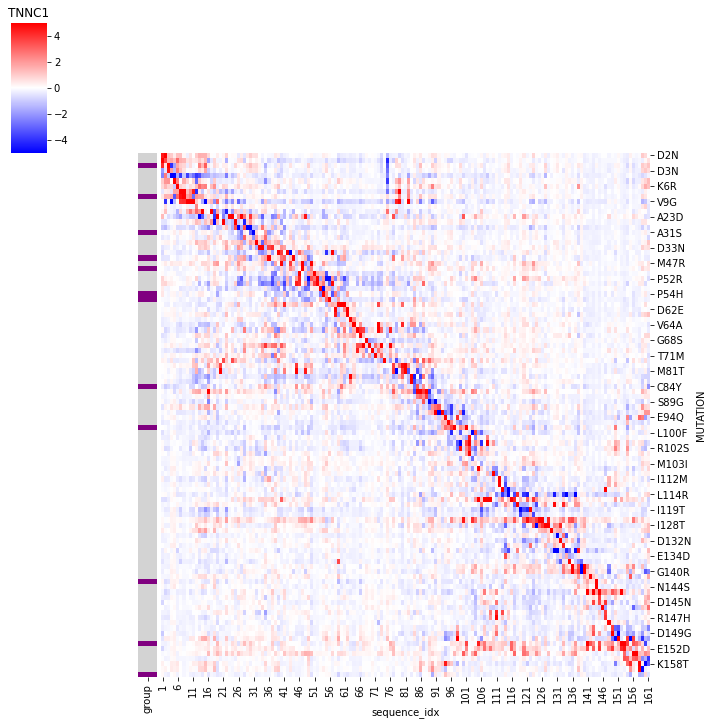

<Figure size 1584x7776 with 0 Axes>

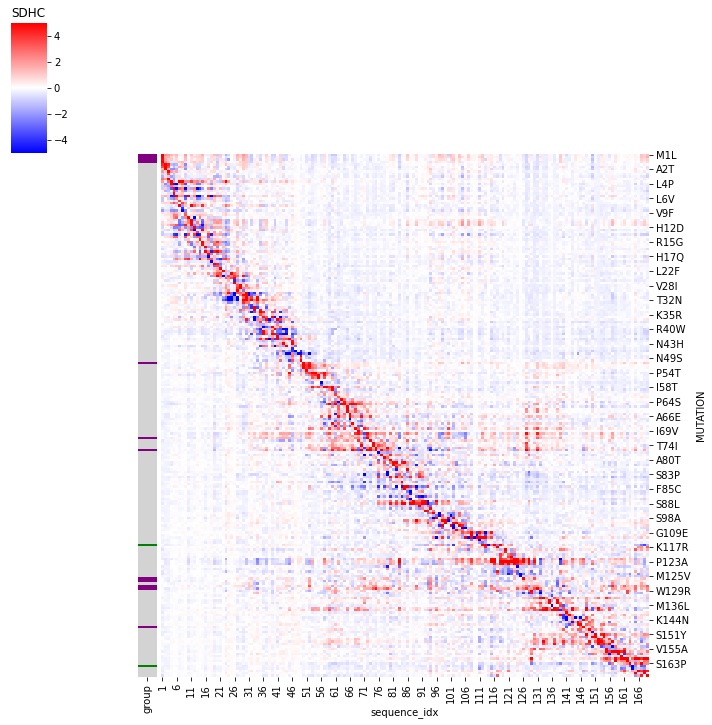

<Figure size 1584x3708 with 0 Axes>

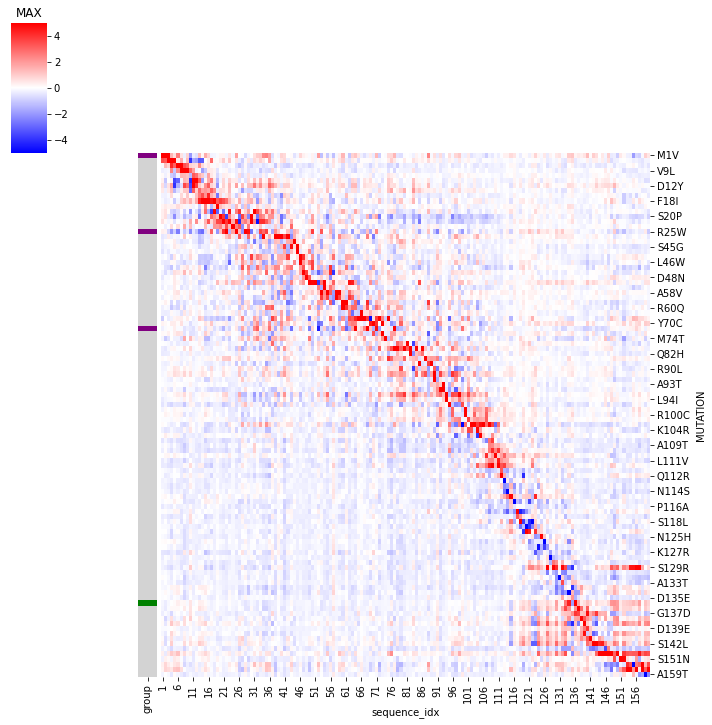

<Figure size 1584x5076 with 0 Axes>

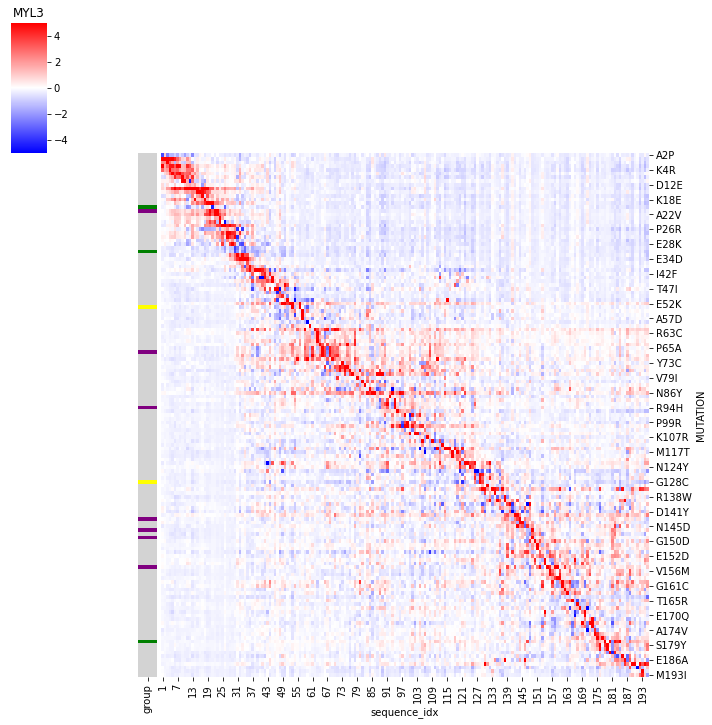

<Figure size 1584x5652 with 0 Axes>

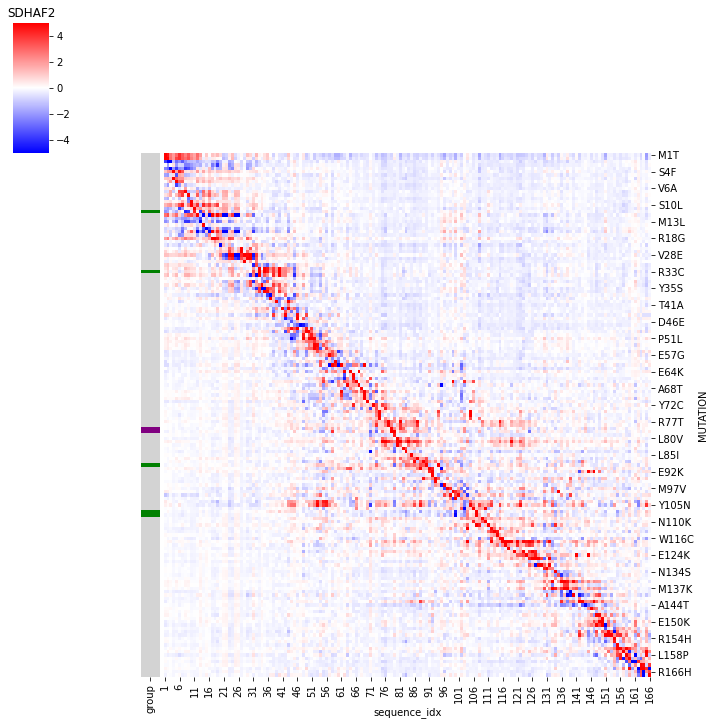

<Figure size 1584x5796 with 0 Axes>

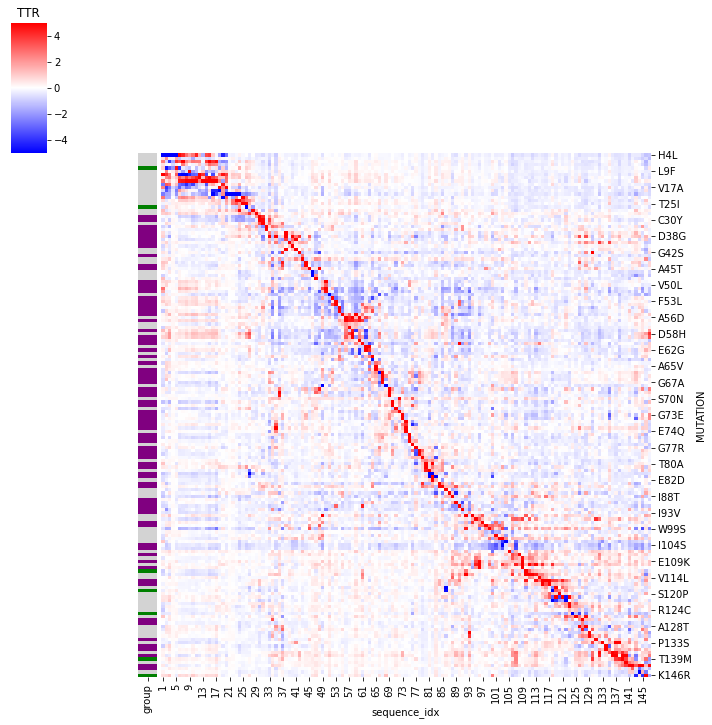

<Figure size 1584x8280 with 0 Axes>

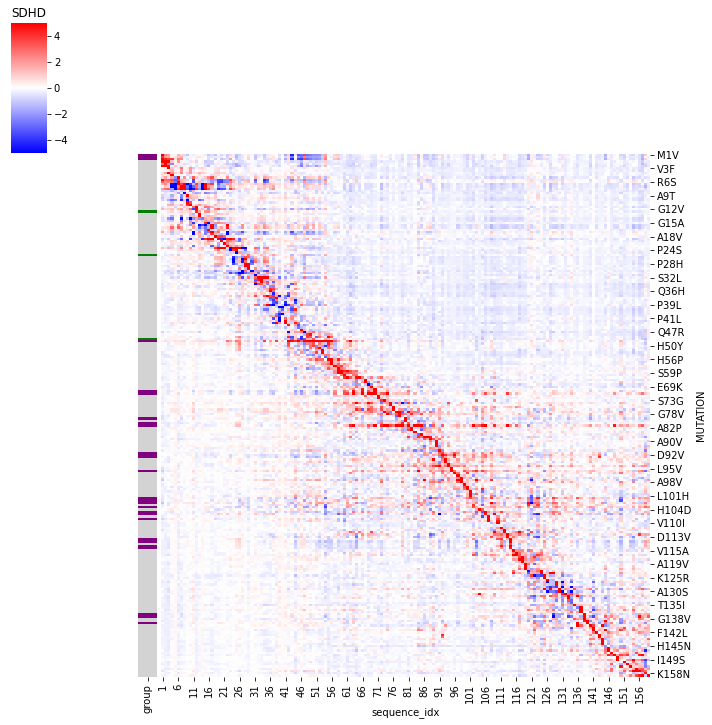

<Figure size 1584x6120 with 0 Axes>

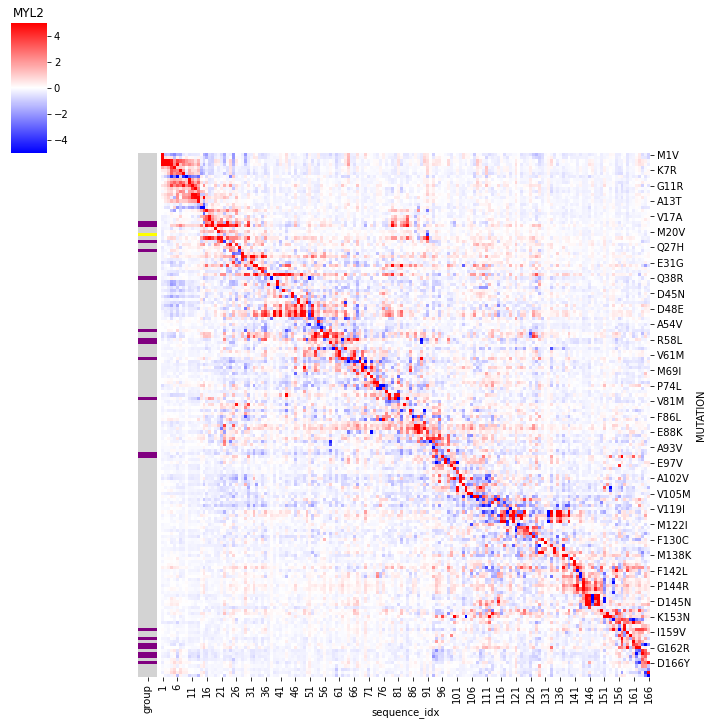

In [82]:
import os
from scipy.stats.stats import zscore
def plot_muts(fname, by_group=False):
    mutscores_df = pd.read_csv(fname, sep='\t')
    mutscores_df = mutscores_df.assign(
        wt_residue=lambda df:df['MUTATION'].apply(lambda x: x[0]),
        mut_idx=lambda df:df['MUTATION'].apply(lambda x: int(x[1:-1])),
    )
    mutscores_df = mutscores_df[ (mutscores_df['residue'].isin(aminoacids))]
    mutscores_df.sort_values('score')
    variant_to_group = mutscores_df.drop_duplicates(['MUTATION', 'GROUP']).set_index('MUTATION')['GROUP'].to_dict()
    variant_colors = {'VUS':'lightgray', 'P/LP':'purple', 'B/LB':'green', 'Other':'yellow'}
    if by_group:
        for group in mutscores_df['GROUP'].unique():
            plt.figure(figsize=(22, len(mutscores_df['MUTATION'].unique()) ))
            sns.heatmap(
                data=(mutscores_df
                      .query(f"GROUP == '{group}'")
                      .groupby(['MUTATION', 'sequence_idx'])['score'].median()
                      .reset_index()
                      .pivot(index='MUTATION', columns='sequence_idx', values='score')
                      .assign(mut_idx=lambda df:df.index.map(lambda x: int(x[1:-1])))
                      .sort_values('mut_idx')
                      .drop('mut_idx', axis=1)
                     ),
                cmap='viridis'
            )
            plt.title(mutscores_df['GENE'].values[0] + ' ' + group)
    else:
        plt.figure(figsize=(22, len(mutscores_df['MUTATION'].unique()) * 0.5))
        mat = (mutscores_df
                  .groupby(['MUTATION', 'sequence_idx'])['score'].mean()
                  .reset_index()
                  .pivot(index='MUTATION', columns='sequence_idx', values='score')
                  .assign(mut_idx=lambda df:df.index.map(lambda x: int(x[1:-1])), group=lambda df:df.index.map(lambda x: variant_to_group[x]))
                  .sort_values('mut_idx')
                  .drop('mut_idx', axis=1)
                 )
        sns.clustermap(
            data=mat.drop('group', axis=1).apply(zscore, axis=0),
            cmap='bwr',
            vmax=5,
            vmin=-5,
            col_cluster=False,
            row_cluster=False,
            row_colors=mat['group'].apply(lambda x: variant_colors[x]) 
        )
        plt.title(mutscores_df['GENE'].values[0])

dr = 'results_esm2_vs_wt/'
for fname in os.listdir(dr):
    if fname.endswith('.tsv') and fname.startswith('mutscan'):
        plot_muts(dr + fname)


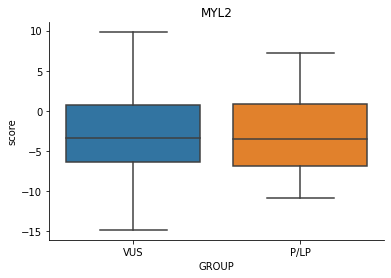

In [78]:
sns.boxplot(
    data=(mutscores_df
          .groupby(['MUTATION', 'GROUP', 'sequence_idx'])['score'].max()
          .reset_index()
          .query('score > 0.01 | score < -0.01')
         ),
    x='GROUP',
    y='score'
)
plt.title(mutscores_df['GENE'].values[0])
sns.despine()